<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/Hate_speech_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip install keras-preprocessing

In [134]:
!pip install textblob

In [135]:
!pip install wordcloud

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import tensorflow as tf
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

## Load in the data.

In [137]:
# read in the facebook data
facebook_hate = pd.read_csv("/content/drive/MyDrive/swahildataset/fb/hate/hate/fabook_data.csv")
facebook_more = pd.read_csv("/content/drive/MyDrive/swahildataset/fb/hate/hate/more_not.csv")
facebook_non_hate = pd.read_csv("/content/drive/MyDrive/swahildataset/fb/hate/hate/facebook_not_hate")
len(facebook_hate), len(facebook_non_hate)

(23650, 11079)

In [138]:
# combine the facebook datasets
facebook_df = pd.concat([facebook_non_hate,facebook_more, facebook_hate], axis=0)
facebook_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,3
1,picha ya siku,0
2,lazima iphone itajwe,0
3,man u wakimuona mzize wanapita naye,0
4,endelea kuchapa kazi kilimo kinalipa,0


In [139]:
len(facebook_df)

36125

In [140]:
# Read in the twitter data
twitter_data = pd.read_csv("/content/drive/MyDrive/swahili/data/data/raw_data/compine.csv")
len(twitter_data)

78297

In [141]:
# Concatinate datasets
swahili_df = pd.concat([facebook_df, twitter_data], axis=0)
swahili_df.head(), len(swahili_df)

(                                                text label
 0  vipaji vinatengenezwarais wa jamhuri ya muunga...     3
 1                                      picha ya siku     0
 2                               lazima iphone itajwe     0
 3                man u wakimuona mzize wanapita naye     0
 4              endelea kuchapa kazi  kilimo kinalipa     0,
 114422)

In [142]:
len(swahili_df)

114422

In [143]:
swahili_df["label"].value_counts()

,count
label,
0,61850
1,17839
1,7615
2,3961
2,3639
0,3558
6,2729
4,2288
3,2277


In [144]:
# remove the rows that contains strings
mask = swahili_df["label"].isin(["Kazi", "Mtoto", "Usiku", "Siku",
                               "Nyota", "Mwezi", "Jua", "Kitabu", "Shule",
                               "Rafiki", "Upendo", "Nyumba", "Chakula", "Maji",
                               "Tafadhali", "Kwaheri", "Habari", "Swahili", "label",
                                "Asante", "Ndiyo", "Hapana"])
swahili_df = swahili_df[~mask]

In [145]:
swahili_df['label'].value_counts()

,count
label,
0,61850
1,17839
1,7615
2,3961
2,3639
0,3558
6,2729
4,2288
3,2277


In [146]:
print(swahili_df['label'].dtype)

swahili_df['label'] = pd.to_numeric(swahili_df['label'], errors='coerce').fillna(0).astype(int)
swahili_df.drop_duplicates(inplace=True)
swahili_df = swahili_df.reset_index(drop=True)
print(swahili_df.columns)

object
Index(['text', 'label'], dtype='object')


In [147]:
label_mapping = {
    0: 'not_hate',
    1: 'offensive',
    2: 'sexual',
    3: 'gender',
    4: 'disability',
    5: 'race',
    6: 'cronical_disease',
    7: 'religion',
    8: 'tribe',
}
swahili_df['label'] = swahili_df['label'].replace(label_mapping)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Data Cleaning and Preprocessing

## Lowacasing all the letters

In [148]:
swahili_df['text'] = swahili_df['text'].str.lower()
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Remove hastags and mentions

In [149]:
import re

In [150]:
swahili_df['text'] =swahili_df['text'].apply(str)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [151]:
# Remove all mentions.
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [152]:
# Remove all hashtags
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("#[A-Za-z0-9_]+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Removing links

In [153]:
# Remove https links
swahili_df['text'] = swahili_df.apply(lambda row: re.sub(r"http\S+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [154]:
# Remove www. links
swahili_df['text'] = swahili_df.apply(lambda row: re.sub(r"www. \S+","", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


## Removing the punctuations

In [155]:
swahili_df['text'] = swahili_df.apply(lambda row: re.sub('[()!?]'," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [156]:
swahili_df['text'] = swahili_df.apply(lambda row: re.sub('\[.*?\]'," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [157]:
## Removing all non-alphanumeric characters
swahili_df['text'] = swahili_df.apply(lambda row: re.sub("[^a-zA-Z0-9]"," ", row['text']),axis=1)
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [158]:
# remove blank text rows
print("Total length before cleaning:", len(swahili_df))

blank_rows = swahili_df['text'].str.strip().eq('').fillna(True)
swahili_df = swahili_df[~blank_rows]

print("Total length after cleaning:", len(swahili_df))

Total length before cleaning: 113019
Total length after cleaning: 112734


## Checke and removeing all the duplicate values form the dataset

In [159]:
 # check for the total af duplicate values.
swahili_df['text'].duplicated().sum()

851

In [160]:
# Remove duplicate values on the text column
swahili_df.drop_duplicates(subset=['text'], inplace=True)
swahili_df.head()

<ipython-input-160-2c781d1b12b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swahili_df.drop_duplicates(subset=['text'], inplace=True)


,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [161]:
swahili_df['text'].duplicated().sum()

0

In [162]:
len(swahili_df)

111883

In [163]:
# remove nan values for text col
swahili_df = swahili_df.dropna(subset=['text'])
len(swahili_df)

111883

In [164]:
# Save the data
swahili_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_annotate_swahili_df.csv", index=False)

## Removing numerical values

In [165]:
def cleaning_number(data):
  return re.sub('[0-9]+', '', data)

swahili_df['text']= swahili_df['text'].apply(lambda x: cleaning_number(x))
swahili_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,man u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


#### Replace the english words with their correspondng swahili words

In [166]:
translation_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahiliEng.csv")
translation_df.tail()

,swahili,english
1461,hizi,these
1462,sahihi,signature
1463,miungano,movements
1464,hii,the
1465,finansi,finance


In [167]:
# convert the dataframe to a dictionary
translation_dict = pd.Series(translation_df['swahili'].values,index=translation_df['english']).to_dict()
translation_dict

{'world': 'ulimwengu',
 'land': 'tua',
 'soil': 'udongo',
 'dust': 'vumbi',
 'mud': 'matope',
 'sand': 'mchanga',
 'hill': 'mlima',
 'mountain': 'kilima',
 'cliff': 'mwamba',
 'plain': 'tambarare',
 'valley': 'bonde',
 'island': 'kisiwa',
 'mainland': 'bara',
 'shore': 'pwani',
 'cave': 'pango',
 'water': 'maji',
 'sea': 'bahari',
 'calm': 'shwari',
 'rough': 'kwaruza',
 'foam': 'povu',
 'ocean': 'bahari',
 'lake': 'ziwa',
 'bay': 'ghuba',
 'reef': 'mwamba',
 'lagoon': 'wangwa',
 'cape': 'rasi',
 'wave': 'wimbi',
 'tide': 'kupwa',
 'low tide': 'maji kupwa',
 'high tide': 'maji kujaa',
 'river': 'mto',
 'spring': 'majira ya kuchipua',
 'well': 'kisima',
 'swamp': 'kinamasi',
 'waterfall': 'maporomoko ya maji',
 'forest': 'msitu',
 'woods': 'mwitu',
 'Savanna': 'mbuga',
 'desert': 'nyika',
 'tree': 'mti',
 'stone': 'jiwe',
 'earthquake': 'tetemeko la ardhi',
 'sky': 'anga',
 'sun': 'jua',
 'moon': 'mwezi',
 'star': 'nyota',
 'lightening': 'radi',
 'thunder': 'ngurumo',
 'storm': 'kimbung

In [168]:
## Function to replace words using the dictionary
def translate_sentence(sentence, translation_dict):
  words = sentence.split()
  translated_words = [translation_dict.get(word, word) for word in words]
  return ' '.join(translated_words)

# apply the fuction to swahili df
swahili_df['text'] = swahili_df['text'].apply(lambda x: translate_sentence(x, translation_dict))
swahili_df

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate
...,...,...
113014,sisi ni wasomi taifa linatutegemea na tuna juk...,not_hate
113015,usikose kusikiliza kipindi cha jilawi kupitia ...,cronical_disease
113016,wizara ya elimu sayansi na teknolojia yaendele...,not_hate
113017,kila la kheri,not_hate


In [169]:
# Save the data
swahili_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_swahili_df.csv", index=False)

In [170]:
# Load in the Cleaned dataset
cleaned_df = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/cleaned_swahili_df.csv")
cleaned_df.head(), len(cleaned_df)

(                                                text     label
 0  vipaji vinatengenezwarais wa jamhuri ya muunga...    gender
 1                                      picha ya siku  not_hate
 2                               lazima iphone itajwe  not_hate
 3           mwanaume u wakimuona mzize wanapita naye  not_hate
 4               endelea kuchapa kazi kilimo kinalipa  not_hate,
 111883)

## EDA

### Define and remove all the stop words in Kiswahili and English

In [171]:
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [172]:
# Check for duplicate based on text column
duplicate_rows = cleaned_df.duplicated(subset=['text'])

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()

print("Number of duplicate rows:", num_duplicates)
print(len(cleaned_df))
cleaned_df = cleaned_df.drop_duplicates(subset=['text'])
print(len(cleaned_df))

Number of duplicate rows: 3996
111883
107887


In [173]:
eng_stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'wewe', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [174]:
STOPWORDS = set(eng_stopwordlist)
def cleaning_stopwords(text, stopwords):
  return " ".join([word for word in str(text).split() if word not in stopwords])
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: cleaning_stopwords(text, STOPWORDS))
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


### Removing white white spaces.

In [175]:
def remove_whitespace(text):
  return " ".join(text.split())
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: remove_whitespace(text))
cleaned_df.head(10)

,text,label
0,vipaji vinatengenezwarais wa jamhuri ya muunga...,gender
1,picha ya siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate
5,kazi ipo,not_hate
6,quote picha uliowahi kupiga usiku kwenye simu ...,not_hate
7,chelsea kuweni serious au mnataka mjitoe kwa m...,not_hate
8,kwa hiyo hautogombea tena,not_hate
9,akunti usipost muda mrefu followers lazima wap...,not_hate


In [176]:
swahili_stopwords = pd.read_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahili_stopwords.csv")
len(swahili_stopwords)

255

In [177]:
swa_stopwords = swahili_stopwords['StopWords'].tolist()

In [178]:
# Remove all swahili stopewords
STOPWORDS = set(swa_stopwords)
cleaned_df['text'] = cleaned_df['text'].apply(lambda text: cleaning_stopwords(text, STOPWORDS))
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais jamhuri muungano tan...,gender
1,picha siku,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


In [179]:
# save the dataset again
cleaned_df.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/swahili_nostop_df.csv")

### Removing most used words.

In [180]:
from collections import Counter
count = Counter()
for text in cleaned_df["text"].values:
    for word in text.split():
        count[word] += 1
count.most_common(20)

[('watu', 9717),
 ('ku', 9288),
 ('mtu', 9140),
 ('wako', 8586),
 ('huyu', 7153),
 ('kuna', 6802),
 ('leo', 6379),
 ('ndio', 6264),
 ('siku', 6231),
 ('mungu', 6096),
 ('kazi', 5127),
 ('mama', 4920),
 ('maisha', 4777),
 ('rais', 4542),
 ('mwanaume', 4513),
 ('kitu', 4285),
 ('mwanamke', 4254),
 ('mtoto', 4192),
 ('maana', 4135),
 ('wangu', 4011)]

In [181]:
FREQWORDS = set([w for (w, wc) in count.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
cleaned_df["text"] = cleaned_df["text"].apply(lambda text: remove_freqwords(text))
cleaned_df.head()

,text,label
0,vipaji vinatengenezwarais jamhuri muungano tan...,gender
1,picha,not_hate
2,lazima iphone itajwe,not_hate
3,mwanaume u wakimuona mzize wanapita naye,not_hate
4,endelea kuchapa kazi kilimo kinalipa,not_hate


### Plot a cloud of words for hate tweets

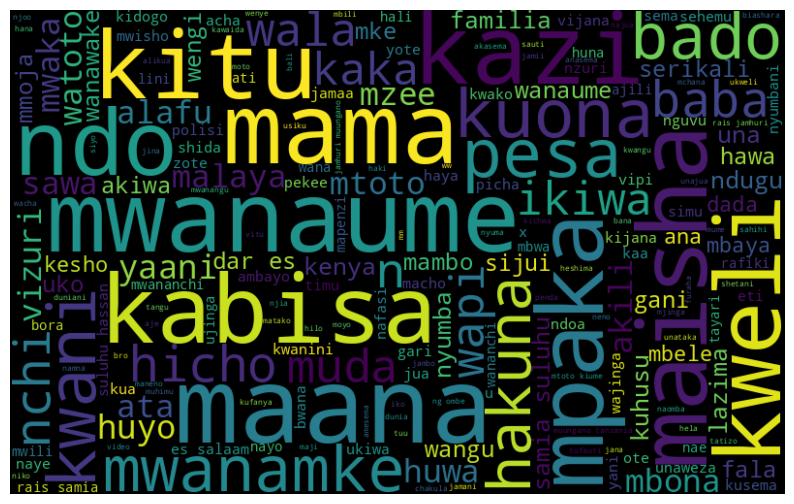

In [182]:
%matplotlib inline
from wordcloud import WordCloud
normal_words =' '.join([text for text in cleaned_df['text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


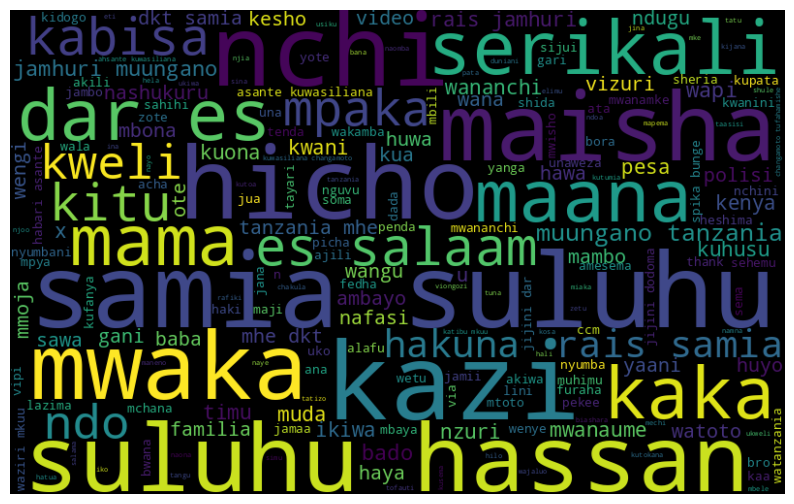

In [183]:
# Check if there are any normal words
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'not_hate']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

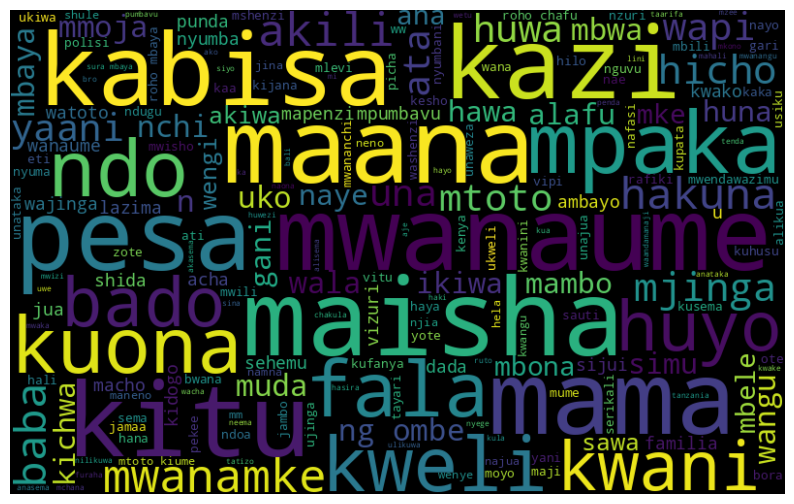

In [184]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'offensive']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

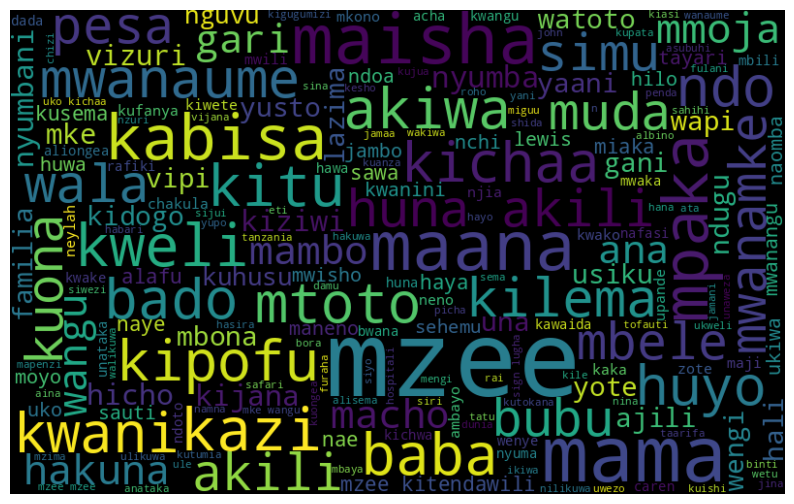

In [185]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'disability']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

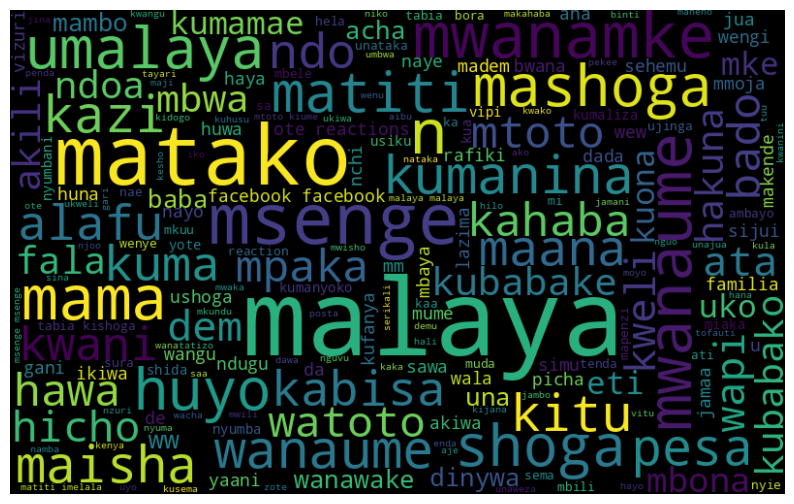

In [186]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'sexual']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

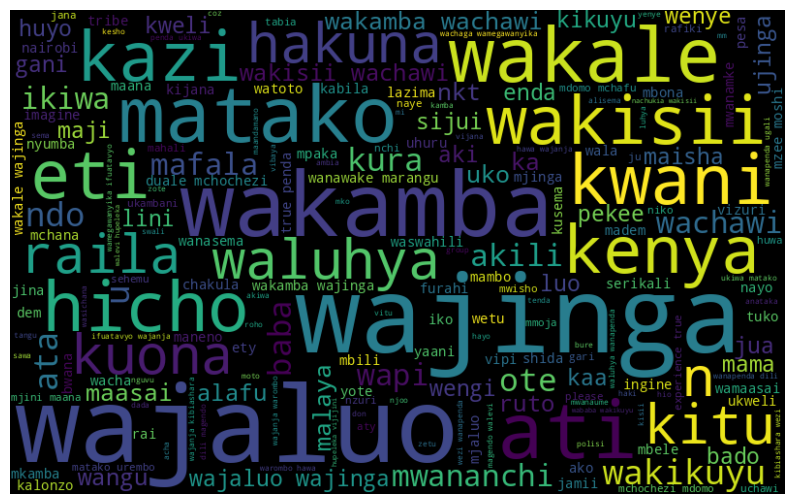

In [187]:
normal_words =' '.join([text for text in cleaned_df['text'][cleaned_df['label'] == 'tribe']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

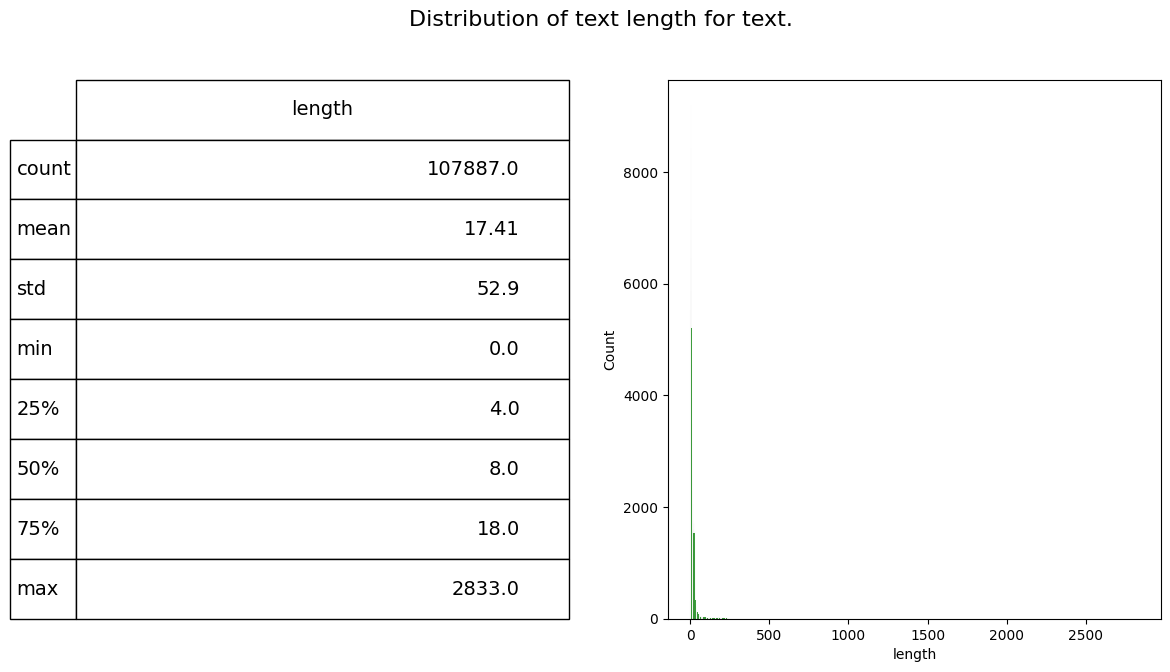

In [188]:
fig = plt.figure(figsize=(14,7))
cleaned_df['length'] = cleaned_df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(cleaned_df['length'], ax=ax1,color='green')
describe = cleaned_df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for text.', fontsize=16)

plt.show()

In [189]:
# Check if the dataset is balanced
cleaned_df['label'].value_counts()

,count
label,
not_hate,61665
offensive,24349
sexual,7220
disability,3618
gender,3262
cronical_disease,3101
tribe,2203
religion,1430
race,1039


In [190]:
# shuffle the dataset
cleaned_df_shuffled = cleaned_df.sample(frac=1).reset_index(drop=True)
cleaned_df_shuffled.head()

,text,label,length
0,mamadou samake dimba misso misondo mpira dj vi...,not_hate,23
1,ft yanga sc mtibwa sukari,not_hate,5
2,dumu sifuri nyamaa,not_hate,3
3,yeah inua weights kifua onyesha us kifua wanna...,not_hate,10
4,oyaaa una kauli mbayaa,not_hate,4


In [191]:
#save the shuffled data
cleaned_df_shuffled.to_csv("/content/drive/MyDrive/swahili/data/data/final_datasets/shuffled_swahili_df.csv", index=False)

In [192]:
# Visualize random traning examples.
import random
random_index = random.randint(0, len(cleaned_df_shuffled))
for row in cleaned_df_shuffled[['text', 'label']][random_index:random_index+5].itertuples():
  _, text, label = row
  # Check if the label is not 'non_hate' before printing '(hate_speech)'
  print(f'Labels: {label}', '(hate_speech)' if label != 'non_hate' else '(Note hate_speech)')
  print(f'Text:\n{text}\n')
  print("----------------------\n")

Labels: offensive (hate_speech)
Text:
mumeanza comment kuhusu mambo ati nilikuwa nilikuwa vipi mnakosa kuelewa nilipokuwa nimepoteza kazi nilikuja nikaandika wateja wangu wengi walikuwa facebook hakuna mahali nilisema nataka kufa kujiua nilipo ona nimezidiwa nilipack vitu nikaenda nairobi inlaw fetita fetite sikua nimechanganyikiwa kuandika vitu ambavyo sivielewi ikiwa unataka kunitaja nitaje uniambie kuona

----------------------

Labels: not_hate (hate_speech)
Text:
genz wakamba tumetenga nyuki billioni ishirini shuguli

----------------------

Labels: not_hate (hate_speech)
Text:
israel mwenda anafunga bao penati

----------------------

Labels: not_hate (hate_speech)
Text:
regina mary ndlodvu anafanya kampeni kuhamasisha jamii kuhusu wenye ulemavu ngozi

----------------------

Labels: offensive (hate_speech)
Text:
nigga alivisit mouthy twitter hunnies kagui kakamsubua hommies like eheria kagui gaka haha jamaa alifukuzwa mwizi pata nyumba lily unaita mbwa huna heshima nikama uko kw

### Split the dataset into training and validation datasets

In [193]:
from sklearn.model_selection import train_test_split

In [194]:
# Slipt the dataset
train_sentences, valid_sentences, train_labels, valid_labels = train_test_split(
    cleaned_df_shuffled['text'].to_numpy(),
    cleaned_df_shuffled['label'].to_numpy(),
    test_size=0.1,
    random_state=42
)
len(train_sentences), len(valid_sentences)

(97098, 10789)

In [195]:
train_sentences[:5], train_labels[:5]

(array(['really eats muranga failure fisi utapasuka msamba',
        'akikuletea dharau zichukue uzihifadhi ipo atazihitaji',
        'chunga mwaya ucje kua mola wko usiwaachie hakikixha mithil asante',
        'ivi nyie watoto ufipa akili gani kwahiyo ruzuku pesa inatolewa kisheria mboyee azile kizembe miaka mamilion yameenda wapi mchaga kilimanjaro unaumia chief wenu kusemwa acha upumbavu kijana mjinga',
        'diploma harambee'], dtype=object),
 array(['offensive', 'not_hate', 'sexual', 'offensive', 'not_hate'],
       dtype=object))

## Convert Text to Numbers.

* Tokenization - Direxct mapping of tokens to numbers
* Embedding - Mapping of words to vectors

### Text Vectorization(Tokenization)

In [196]:
len(train_sentences[0]. split())

7

In [197]:
# Find the average number of tokens in the training datasets.
round(sum([len(str(i).split()) for i in train_sentences])/len(train_sentences))

17

In [198]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# set text vexctorization variables
max_vocab_lenght = 20000
max_length = 20

text_vectorizer = TextVectorization(max_tokens=max_vocab_lenght,
                                    output_mode='int',
                                    output_sequence_length=max_length,
                                    )

In [199]:
# Fit the vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [200]:
# Tokenize a sample sentence
sample_sentence = "huna heshima kabisa"
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 52, 191,  13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [201]:
# choose a random sentence from the training sentences
random_sentence = random.choice(train_sentences)
print(f'Original text: \n {random_sentence}\n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text: 
 mkuu kanisa kkkt dk fredrick shoo amesema kkkt inaamini maoni yaliyowasilishwa viongozi dini kufanyia marekebisho mkataba ushirikiano kiserikali serikali tanzania imarati dubai kuhusu uendeshaji bandari yatafanyiwa kazi

 Vectorized version:


<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[  32,  381, 7279, 1249, 6723, 7626,  217, 7279,    1,  652,    1,
         235,  307, 3618, 4347, 1036, 1023, 5857,   22,   12]])>

In [202]:
# Get unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'10 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 20000
10 most common words: ['', '[UNK]', 'kazi', 'mama', 'maisha', 'mwanaume', 'rais', 'mwanamke', 'kitu', 'mtoto']
5 least common words: ['sapa', 'sanusi', 'sanjari', 'sanifu', 'sandy']


### Create an Embedding

In [203]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_lenght,
                             output_dim=128,
                             input_length=max_length)
embedding

In [204]:
# visualize after embedding
print(f'Original text: \n {random_sentence} \
      \n\nEmbedded version: ')
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 mkuu kanisa kkkt dk fredrick shoo amesema kkkt inaamini maoni yaliyowasilishwa viongozi dini kufanyia marekebisho mkataba ushirikiano kiserikali serikali tanzania imarati dubai kuhusu uendeshaji bandari yatafanyiwa kazi       

Embedded version: 


<tf.Tensor: shape=(1, 20, 128), dtype=float32, numpy=
array([[[-0.00570707,  0.04758492,  0.03725998, ...,  0.04222614,
         -0.04825908, -0.04684514],
        [-0.04223735, -0.03360406,  0.00757641, ...,  0.0400669 ,
         -0.0419709 , -0.0229762 ],
        [-0.02771472,  0.03350086,  0.01346357, ...,  0.03374577,
         -0.03160945, -0.04452772],
        ...,
        [-0.03663865,  0.01155315, -0.02325902, ..., -0.01002216,
         -0.03667646, -0.01901346],
        [-0.02132374,  0.03050096,  0.03705374, ..., -0.02350366,
          0.01158395, -0.01744227],
        [-0.00939937,  0.04247044, -0.04959375, ..., -0.04128151,
          0.0310586 ,  0.03150512]]], dtype=float32)>

## Modeling
### Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
# Create a data pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Baseline model evaluation
baseline_score = model_0.score(valid_sentences, valid_labels)
print(f"baseline model score: {baseline_score*100:.2f}%")
print(classification_report(valid_labels, model_0.predict(valid_sentences)))

baseline model score: 68.70%
                  precision    recall  f1-score   support

cronical_disease       1.00      0.03      0.06       340
      disability       1.00      0.04      0.08       352
          gender       1.00      0.00      0.01       328
        not_hate       0.67      0.99      0.80      6237
       offensive       0.73      0.48      0.58      2322
            race       0.00      0.00      0.00       119
        religion       0.00      0.00      0.00       147
          sexual       0.98      0.15      0.25       742
           tribe       1.00      0.01      0.02       202

        accuracy                           0.69     10789
       macro avg       0.71      0.19      0.20     10789
    weighted avg       0.73      0.69      0.61     10789



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions
baseline_preds = model_0.predict(valid_sentences)
baseline_preds[:10]

array(['not_hate', 'not_hate', 'not_hate', 'not_hate', 'offensive',
       'not_hate', 'not_hate', 'offensive', 'not_hate', 'not_hate'],
      dtype='<U16')

In [ ]:
valid_sentences[:20]

array(['kheri kuzaliwa mheshimiwa dkt salim ahmed salim mtumishi mahiri umma watanzania afrika dunia miongo minne adhimu kumbukumbu miaka kuzaliwa kwako tunakushukuru utumishi uliotukuka nchi',
       'wakisii nyamira wachawi vipi sane ungua kaa cows',
       'repost wanangu mkwanja upo njee njee odds sportpesa game spain egypt mpe spain ashinde mazima bofya link weka dau lako uweze kupata mpunga multibet bonus',
       'orange pya eusi',
       'msumeno baringo county specific trees makaa burning fikiri hicho nzuri dhana',
       'tangu jana wengi walikuwa hamu kumsikiliza kumuuliza maswali edward lowassa mbunge',
       'akiwa rapper afrika kusini mapema xxl clouds fm redio kesho',
       'habari vituko binti miaka aliyefariki mwaka uingereza saratani ashinda kesi akijua atakufa binti huyo matumaini makubwa kuishi alijikuta akihifadhiwa jokofu dawa ikipatikana arudi duniani kuishi alitumia wiki akitafuta namna bora ambayo anaweza kuhifadhiwa vizuri dawa ikipatikana aweze kuishi nyuma

In [ ]:
# Model Evaluation based on: accuracy score, precision score, recall, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Convert predictions to numerical type if they are strings
  if isinstance(y_pred[0], str):
    y_pred = y_pred.astype(int)  # Assuming labels are '0' and '1'

  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate probabilities for ROC AUC score
  y_pred_proba = model_0.predict_proba(valid_sentences)[:, 1] # Assuming model_0 is your trained model
  # Set multi_class parameter for roc_auc_score
  roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')*100  # Using 'ovr' strategy
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
      y_true,
      y_pred,
      average="weighted")
  model_results = {
      "accuracy": model_accuracy,
      "precision": (model_precision)*100,
      "recall": (model_recall)*100,
      "f1": (model_f1)*100,
      "ROC": roc
  }
  return model_results

In [ ]:
# f-1 score and ROC_AUC
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(valid_labels, baseline_preds))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79      6124
           1       0.76      0.45      0.57      2458
           2       0.97      0.14      0.24       733
           3       1.00      0.00      0.01       332
           4       0.89      0.05      0.09       349
           5       0.00      0.00      0.00       111
           6       1.00      0.03      0.06       313
           7       0.00      0.00      0.00       153
           8       0.00      0.00      0.00       216

    accuracy                           0.68     10789
   macro avg       0.59      0.18      0.19     10789
weighted avg       0.70      0.68      0.60     10789



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  """
  plot_confusion_matrixtrix using Seaborn's heatmap().
  """
  fig, ax = plt.subplots(figsize=(5, 5))
  ax = sns.heatmap(confusion_matrix(y_true, y_pred),
                    annot=True,
                    cbar=False,
                    fmt='d',
                    )
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

### SVM

**A support vector machine (SVM) is a machine learning algorithm that uses supervised learning models to solve complex classification, regression, and outlier detection problems by performing optimal data transformations that determine boundaries between data points based on predefined classes, labels, or outputs. SVMs are widely adopted across disciplines such as healthcare, natural language processing, signal processing applications, and speech & image recognition fields**

In [ ]:
%%time
from sklearn.svm import SVC, LinearSVC
model_1_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

# fit the model
model_1_svm.fit(train_sentences, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


CPU times: user 7.74 s, sys: 42 ms, total: 7.78 s
Wall time: 7.77 s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [ ]:
model_1_svm.score(valid_sentences, valid_labels)
print(classification_report(valid_labels, model_1_svm.predict(valid_sentences)))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      6124
           1       0.85      0.82      0.83      2458
           2       0.90      0.86      0.88       733
           3       0.86      0.71      0.78       332
           4       0.87      0.71      0.78       349
           5       0.92      0.61      0.74       111
           6       0.86      0.77      0.81       313
           7       0.93      0.84      0.88       153
           8       0.84      0.57      0.68       216

    accuracy                           0.89     10789
   macro avg       0.88      0.76      0.81     10789
weighted avg       0.89      0.89      0.88     10789



In [ ]:
# Make Predictions
model_1_svm_preds = model_1_svm.predict(valid_sentences)
model_1_svm_preds[:20]

array(['0', '8', '0', '0', '0', '0', '0', '6', '1', '8', '0', '0', '1',
       '0', '0', '1', '1', '0', '0', '1'], dtype=object)

In [ ]:
# save the model
import pickle
with open("/content/drive/MyDrive/swahili/models/model_1_svm.pkl", "wb") as file:
  pickle.dump(model_1_svm, file)

### ⏳Search for optimal parameters for SVM algotithm

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
model_1_pram = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l1',
                          alpha=0.0001, l1_ratio=0.15,
                          fit_intercept=True, max_iter=1000,
                          tol=0.001, shuffle=True, verbose=0,
                          epsilon=0.1, n_jobs=None, random_state=None,
                          learning_rate='optimal', eta0=0.0,
                          power_t=0.5, early_stopping=False,
                          validation_fraction=0.1, n_iter_no_change=5,
                          class_weight=None, warm_start=False, average=False))
])
model_1_pram.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier(penalty='l1'))])

In [ ]:
model_1_pram.score(valid_sentences, valid_labels)

0.8501251274446195

In [ ]:
# save the model results
with open("/content/drive/MyDrive/swahili/models/model_1_pram.pkl", "wb") as file:
  pickle.dump(model_1_pram, file)

### Logistic regresion
**Logistic Regression is a “Supervised machine learning” algorithm that can be used to model the probability of a certain class or event. It is used when the data is linearly separable and the outcome is binary or dichotomous in nature.**


In [ ]:
from sklearn.linear_model import LogisticRegression
model_logisctic = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

model_logisctic.fit(train_sentences, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [ ]:
# find the model score
model_logisctic.score(valid_sentences, valid_labels)

0.8656965427750487

In [ ]:
# make predictins
model_logisctic_preds = model_logisctic.predict(valid_sentences)
model_logisctic_preds[:20]

array(['0', '8', '0', '0', '0', '0', '0', '6', '1', '8', '0', '0', '1',
       '0', '0', '1', '1', '0', '0', '1'], dtype=object)

In [ ]:
# classification report
print(classification_report(valid_labels, model_logisctic_preds))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6124
           1       0.84      0.81      0.82      2458
           2       0.90      0.78      0.84       733
           3       0.84      0.63      0.72       332
           4       0.85      0.60      0.71       349
           5       0.93      0.46      0.61       111
           6       0.85      0.62      0.72       313
           7       0.92      0.56      0.69       153
           8       0.80      0.51      0.63       216

    accuracy                           0.87     10789
   macro avg       0.87      0.66      0.74     10789
weighted avg       0.87      0.87      0.86     10789



In [ ]:
# Save
with open("/content/drive/MyDrive/swahili/models/model_logisctic.pkl", "wb") as file:
  pickle.dump(model_logisctic, file)

#### ⌛ Logistic regression hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
small_param_grid = [
    {
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__stop_words': [None],
        'tfidf__tokenizer': [None],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'tfidf__ngram_range': [(1, 1)],
        'tfidf__stop_words': [None],
        'tfidf__tokenizer': [None],
        'tfidf__use_idf': [False],
        'tfidf__norm': [None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

lr_grid_search = GridSearchCV(model_logisctic, small_param_grid,
                              cv=5,
                              scoring='accuracy',
                              verbose=True)
lr_grid_search.fit(train_sentences, train_labels)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__penalty': ['l1', 'l2'],
                          'tfidf__ngram_range': [(1, 1)], 'tfidf__norm': [None],
                          'tfidf__stop_words': [None],
                          'tfidf__tokenizer': [None],
                          'tfidf__use_idf': [False]},
                         {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'clf__penalty': ['l1', 'l2'],
                          'tfidf__ngram_range': [(1, 1)], 'tfidf__norm': [None],
                          'tfidf__stop_words': [None],
                          'tfidf__tokenizer': [None],
                          'tfidf__use_idf': [False]}],
             scoring='accuracy', verbose=True)

In [ ]:
# score the model
lr_grid_search.score(valid_sentences, valid_labels)

0.892390397627213

In [ ]:
# make predictions
lr_grid_search_preds = lr_grid_search.predict(valid_sentences)
lr_grid_search_preds[:10]

array(['0', '8', '0', '0', '0', '0', '0', '6', '1', '8'], dtype=object)

In [ ]:
# Find the best params
lr_grid_search.best_params_

{'clf__C': 1,
 'clf__penalty': 'l2',
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': None,
 'tfidf__stop_words': None,
 'tfidf__tokenizer': None,
 'tfidf__use_idf': False}

In [ ]:
# save the model.
with open("/content/drive/MyDrive/swahili/models/model_logisctic_grid_search.pkl", "wb") as file:
  pickle.dump(lr_grid_search, file)


In [ ]:
# find the prediction probabilities for the model
prediction_probs = lr_grid_search.predict_proba(valid_sentences)
prediction_probs[:10]

array([[9.88364722e-01, 5.70617381e-03, 9.13106592e-04, 6.58701139e-04,
        2.79108669e-04, 3.56923987e-03, 2.12767546e-04, 2.78884476e-04,
        1.72954422e-05],
       [6.47512519e-02, 1.70110823e-01, 3.93846259e-03, 2.34819635e-04,
        2.41161405e-03, 4.12910271e-03, 2.80995456e-03, 1.38861576e-02,
        7.37727814e-01],
       [9.35948531e-01, 4.18549572e-02, 8.18583072e-03, 8.93032644e-03,
        2.45745941e-03, 3.32307930e-04, 1.51652551e-03, 7.07333694e-04,
        6.67277676e-05],
       [9.65362079e-01, 2.34225988e-02, 3.22705914e-03, 2.16604799e-03,
        1.10002624e-03, 9.69022616e-04, 1.79861709e-03, 1.17641606e-03,
        7.78132650e-04],
       [9.73572468e-01, 2.05394632e-02, 2.09966586e-03, 2.42629876e-04,
        1.03758117e-03, 5.35837369e-04, 4.80828448e-04, 5.13112294e-04,
        9.78413775e-04],
       [9.62168226e-01, 2.78500434e-02, 2.40389326e-03, 1.92427755e-03,
        3.27383470e-03, 3.62642978e-04, 7.89008653e-04, 6.97751118e-04,
        5.3

### DecisionTreeClassifier

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

model_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier())
])
model_dt.fit(train_sentences, train_labels)

CPU times: user 7min 37s, sys: 348 ms, total: 7min 37s
Wall time: 7min 40s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', DecisionTreeClassifier())])

In [ ]:
# score the model
model_dt.score(valid_sentences, valid_labels)

0.8815460190935211

In [ ]:
# make predictions
model_dt_preds = model_dt.predict(valid_sentences)
model_dt_preds[:10]

array(['0', '8', '0', '0', '0', '0', '0', '6', '1', '8'], dtype=object)

In [ ]:
valid_labels[:10]

array(['0', '8', '0', '0', '0', '0', '0', '6', '1', '8'], dtype=object)

In [ ]:
# create a text vectrizer for the training and validation sentences
x_train_tfv = text_vectorizer(train_sentences)
x_valid_tfv = text_vectorizer(valid_sentences)

In [ ]:
# comapre the cost-complexity prunning path
%%time
tree_model = model_dt.named_steps['clf']
path = tree_model.cost_complexity_pruning_path(x_train_tfv, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)
print(impurities)

[0.00000000e+00 0.00000000e+00 3.77263648e-08 ... 1.47711767e-03
 2.86796849e-03 1.32085265e-02]
[0.00614422 0.00614422 0.00614426 ... 0.59789983 0.6007678  0.61397632]
CPU times: user 8.67 s, sys: 7.24 ms, total: 8.67 s
Wall time: 8.75 s


Text(0.5, 1.0, 'Total Impurity vs Effective alpha for training set')

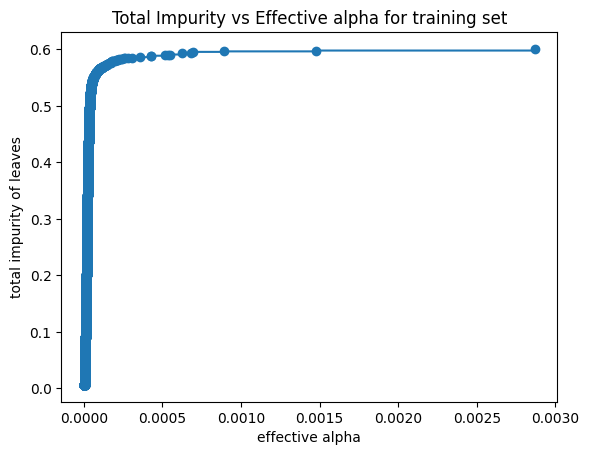

In [ ]:
# plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total Impurity vs Effective alpha for training set')

In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_dt.pkl", "wb") as file:
  pickle.dump(model_dt, file)

### ⏳ Hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
dt_params = {
   'max_depth': [2, 3, 5, 10, 20, 27],
   'min_samples_leaf': [5, 10, 20, 50, 100],
   'criterion': ['gini', 'entropy']
}

In [ ]:
# Initiate grid search model
dt_grid_search = GridSearchCV(estimator=model_dt,
                              param_grid={'clf__' + key: value for key, value in dt_params.items()},
                             cv=5,
                              n_jobs=-1,
                              scoring='accuracy',
                             verbose=True)
dt_grid_search.fit(train_sentences, train_labels)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 3, 5, 10, 20, 27],
                         'clf__min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=True)

In [ ]:
# score
dt_grid_search.score(valid_sentences, valid_labels)

0.7394568542033553

#### ⌛ find the optimal value for ccp_alpha

In [ ]:
## find the optimal value for ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmin(impurities)]
optimal_ccp_alpha

0.0

In [ ]:
%%time
tree_model.set_params(ccp_alpha=optimal_ccp_alpha)
tree_model = tree_model.fit(x_train_tfv, train_labels)

CPU times: user 3.79 s, sys: 654 µs, total: 3.79 s
Wall time: 3.87 s


In [ ]:
# make predictions
tree_model_preds = tree_model.predict(x_valid_tfv)
tree_model_preds[:10]

array(['0', '1', '8', '1', '0', '8', '4', '1', '3', '1'], dtype=object)

### RandomForestClassifier

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])
model_rf.fit(train_sentences, train_labels)

CPU times: user 33min, sys: 1.88 s, total: 33min 2s
Wall time: 33min 17s


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [ ]:
# Random forest model score
model_rf_score = model_rf.score(valid_sentences, valid_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

Random forest model score: 87.26%


In [ ]:
model_rf_score = model_rf.score(train_sentences, train_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

In [ ]:
# Make predictions
model_rf_preds = model_rf.predict(valid_sentences)
model_rf_preds[:10]

In [ ]:
# Classification report
print(classification_report(valid_labels, model_rf_preds))

In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_rf.pkl", "wb") as file:
  pickle.dump(model_rf, file)

In [ ]:
model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs= -1,                               random_state=42))
])
model_rf.fit(train_sentences, train_labels)
model_rf_score = model_rf.score(valid_sentences, valid_labels)
print(f"Random forest model score: {model_rf_score*100:.2f}%")

## Deep Modeling

### Recurrent Nural Network(RNN)
#### Model 1: LSTM 1-layer

A long short-term memory network is a type of recurrent neural network (RNN).

* LSTMs are predominantly used to learn, process, and classify sequential data.
* They are user because these networks can learn long-term dependencies between time steps of data.

In [207]:
from tensorflow.keras import layers
import tensorflow as tf

# Sequential model
model_lstm1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_lstm1._name = 'Model_1_dense_sequential'

In [208]:
# Show the model summary.
model_lstm1.summary()

Model: "Model_1_dense_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 20, 128)           2560000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 20, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_3 (Bidirecti  (None, 600)               1029600   
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 600)               0         
                                          

In [209]:
# compile the model
model_lstm1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [210]:
valid_label_series = pd.Series(valid_labels)
valid_label_series.value_counts()

,count
not_hate,6190
offensive,2380
sexual,738
disability,338
gender,324
cronical_disease,316
tribe,237
religion,168
race,98


In [211]:
# model check points
checkpoint_callback = ModelCheckpoint(filepath="lastm-1-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [212]:
# convert string labels to numerical values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.fit_transform(valid_labels)

# is your original labels array
train_labels = tf.keras.utils.to_categorical(train_labels)
valid_labels = tf.keras.utils.to_categorical(valid_labels)

In [213]:
# fit the model
history_model_lstm1 = model_lstm1.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3034/3035 [============================>.] - ETA: 0s - loss: 0.9511 - accuracy: 0.7166

3035/3035 [==============================] - 163s 52ms/step - loss: 0.9510 - accuracy: 0.7166 - val_loss: 0.6389 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 2/10
3034/3035 [============================>.] - ETA: 0s - loss: 0.6730 - accuracy: 0.8187

3035/3035 [==============================] - 157s 52ms/step - loss: 0.6730 - accuracy: 0.8187 - val_loss: 0.5848 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 3/10
3034/3035 [============================>.] - ETA: 0s - loss: 0.6013 - accuracy: 0.8392

3035/3035 [==============================] - 156s 51ms/step - loss: 0.6012 - accuracy: 0.8392 - val_loss: 0.5209 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 4/10
3035/3035 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.8527

3035/3035 [==============================] - 156s 51ms/step - loss: 0.5547 - accuracy: 0.8527 - val_loss: 0.4999 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 5/10
3035/3035 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.8621

3035/3035 [==============================] - 156s 51ms/step - loss: 0.5168 - accuracy: 0.8621 - val_loss: 0.4866 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 6/10
3035/3035 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.8690

3035/3035 [==============================] - 155s 51ms/step - loss: 0.4937 - accuracy: 0.8690 - val_loss: 0.4818 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 7/10
3034/3035 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8730

3035/3035 [==============================] - 155s 51ms/step - loss: 0.4782 - accuracy: 0.8730 - val_loss: 0.4716 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 8/10
3034/3035 [============================>.] - ETA: 0s - loss: 0.4613 - accuracy: 0.8773

3035/3035 [==============================] - 156s 51ms/step - loss: 0.4613 - accuracy: 0.8773 - val_loss: 0.4844 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 9/10
3035/3035 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8796

3035/3035 [==============================] - 155s 51ms/step - loss: 0.4472 - accuracy: 0.8796 - val_loss: 0.4815 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 10/10
3035/3035 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8827

3035/3035 [==============================] - 155s 51ms/step - loss: 0.4358 - accuracy: 0.8827 - val_loss: 0.4806 - val_accuracy: 0.8784 - lr: 0.0010


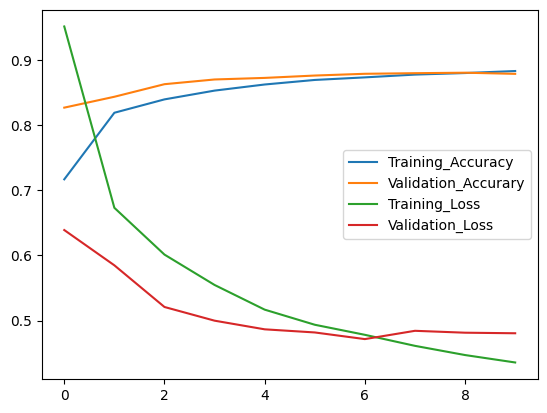

In [214]:
acc = history_model_lstm1.history['accuracy']
val_acc = history_model_lstm1.history['val_accuracy']
loss = history_model_lstm1.history['loss']
val_loss = history_model_lstm1.history['val_loss']
plt.plot(acc, label='Training_Accuracy')
plt.plot(val_acc, label='Validation_Accurary')
plt.plot(loss, label='Training_Loss')
plt.plot(val_loss, label='Validation_Loss')
plt.legend()
plt.show()


### LSTM 2-layers

In [215]:
from tensorflow.keras import layers
import tensorflow as tf

# Sequential model
model_lstm2 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_lstm2._name = 'Model_2_dense_sequential'

In [ ]:
# find the model summary
model_lstm2.summary()

Model: "Model_1_dense_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 128)           2560000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 20, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 600)           1029600   
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 20, 600)           0         
                                          

In [216]:
# Compile the model.
model_lstm2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [217]:
# model check points
checkpoint_callback = ModelCheckpoint(filepath="lastm-2-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [218]:
history_model_lstm2 = model_lstm2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/5
3035/3035 [==============================] - ETA: 0s - loss: 0.6058 - accuracy: 0.8378

3035/3035 [==============================] - 347s 111ms/step - loss: 0.6058 - accuracy: 0.8378 - val_loss: 0.4954 - val_accuracy: 0.8761 - lr: 0.0010
Epoch 2/5
3035/3035 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.8740

3035/3035 [==============================] - 335s 110ms/step - loss: 0.4723 - accuracy: 0.8740 - val_loss: 0.4602 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 3/5
3035/3035 [==============================] - ETA: 0s - loss: 0.4431 - accuracy: 0.8817

3035/3035 [==============================] - 335s 111ms/step - loss: 0.4431 - accuracy: 0.8817 - val_loss: 0.4789 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 4/5
3035/3035 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8863

3035/3035 [==============================] - 335s 110ms/step - loss: 0.4241 - accuracy: 0.8863 - val_loss: 0.4732 - val_accuracy: 0.8784 - lr: 0.0010
Epoch 5/5
3035/3035 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.8888

3035/3035 [==============================] - 334s 110ms/step - loss: 0.4114 - accuracy: 0.8888 - val_loss: 0.4705 - val_accuracy: 0.8790 - lr: 0.0010


In [222]:
def plot_model_training(model_history):
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  plt.plot(acc, label='Training_Accuracy')
  plt.plot(val_acc, label='Validation_Accurary')
  plt.plot(loss, label='Training_Loss')
  plt.plot(val_loss, label='Validation_Loss')
  plt.legend()
  plt.show()

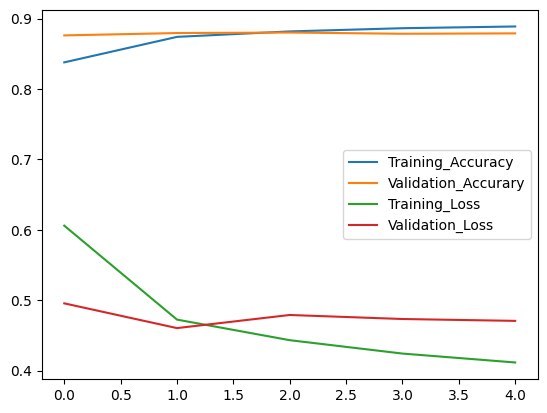

In [223]:
plot_model_training(history_model_lstm2)

In [224]:
# more LSTM hidden layers
# Sequential model
model_lstm5 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),  # Input layer
    text_vectorizer,                            # Text vectorization layer
    embedding,                                  # Embedding layer
    SpatialDropout1D(0.8),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax'),
])

# Name the model
model_lstm5._name = 'Model_5_dense_sequential'

In [226]:
model_lstm5.summary()

Model: "Model_5_dense_sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 20)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 20, 128)           2560000   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 20, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_6 (Bidirecti  (None, 20, 600)           1029600   
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 20, 600)           0         
                                          

In [228]:
model_lstm5.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [229]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-5-layer-best_model.keras", save_best_only=True, monitor="val_acc", mode="max", verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [ ]:
history_model_lstm5 = model_lstm5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=32,
                              validation_data=(valid_sentences, valid_labels),
                              callbacks=callbacks)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 779/3035 [======>.......................] - ETA: 10:30 - loss: 1.0876 - accuracy: 0.6997

In [ ]:
plot_model_training(history_model_lstm5)

### GRU

the GRU have the same features as LSTM cel but hae less parameters

In [ ]:
from tensorflow.keras import regularizers

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_LSTM")

In [ ]:
# compile the model.
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# fit the model.
model_3_history = model_3.fit(train_sentences,
                              train_label,
                              epochs=5,
                              validation_data=(valid_sentences, valid_label))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3035/3035 ━━━━━━━━━━━━━━━━━━━━ 180s 58ms/step - accuracy: 0.2264 - loss: -28.6391 - val_accuracy: 0.2301 - val_loss: -159.7064
Epoch 2/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 197s 56ms/step - accuracy: 0.2253 - loss: -298.4387 - val_accuracy: 0.2301 - val_loss: -168.8597
Epoch 3/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 204s 57ms/step - accuracy: 0.2224 - loss: -72.6962 - val_accuracy: 0.2301 - val_loss: 18.0249
Epoch 4/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 201s 57ms/step - accuracy: 0.2225 - loss: 17.3492 - val_accuracy: 0.2301 - val_loss: 11.2402
Epoch 5/5
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 202s 57ms/step - accuracy: 0.2229 - loss: 9.4304 - val_accuracy: 0.2301 - val_loss: 2.9277


In [ ]:
# make predictions
model_3_pred_probs = model_3.predict(valid_sentences)
print(model_3_pred_probs[:10])

338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
[[0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]
 [0.9920508]]


In [ ]:
# predictions
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0.], dtype=float32)>

In [ ]:
# save the model
with open("/content/drive/MyDrive/swahili/models/model_3_gru.pkl", "wb") as file:
  pickle.dump(model_3, file)

### Model_4: Bidirectional RNN

**Normal RNN's go from left to right (the same way you will read a kiswahili sentence).
The bidirection RNN go from right to let as well as from  left to right**

In [ ]:
# build a bidirectional RNN
def text_augmenter(text):
  return tf.expand_dims(text, axis=0)

inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4_bidirectional = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [ ]:
model_4_bidirectional.summary()

In [ ]:
# Compile the model.
model_4_bidirectional.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
#  fit the model
model_4_biderectional_history = model_4_bidirectional.fit(train_sentences,
                              train_label,
                              epochs=5,
                              validation_data=(valid_sentences, valid_label))

In [ ]:
# evalutate the model
model_4_bidirectional.evaluate(valid_sentences, valid_label)

In [ ]:
# make predictions
model_4_pred_probs = model_4_bidirectional.predict(valid_sentences)
print(model_4_pred_probs[:10])

In [ ]:
# convert the prediction results to compatible features
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0.], dtype=float32)>

### CNN
#### model 5: conv1D

In [ ]:
# Create a ond dimensional convolutional neural  netword layer to  model sequences.
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='valid')(x)
x = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='valid')(x)
X = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5_cnn = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

model_5_cnn.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit
%%time
model_5_cnn_history = model_5_cnn.fit(train_sentences,
                                       train_label,
                                       epochs=5,
                                       validation_data=(valid_sentences, valid_label))


In [ ]:
# find the model summary
model_5_cnn.summary()

In [ ]:
# evaluate cnn model.
model_5_cnn.evaluate(valid_sentences, valid_label)

In [ ]:
# Make predictions
model_5_cnn_pred_probs = model_5_cnn.predict(valid_sentences)
print(model_5_cnn_pred_probs[:10])

In [ ]:
model_5_cnn_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# plot history for loss
def plot_model_training(model_history):
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
# The pabove plots are a clear intication of the model overfitting.
plot_model_training(model_5_cnn_history)

In [ ]:
# use regularization
from tensorflow.keras import regularizers
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(filters=32, kernel_size=5, kernel_regularizer=regularizers.l2(0.01), strides=1, padding='valid')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(filters=32, kernel_size=5, kernel_regularizer=regularizers.l2(0.01), strides=1, padding='valid')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5_cnn = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

model_5_cnn.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# fit and evaluate the model.
model_5_cnn_history = model_5_cnn.fit(train_sentences,
                                       train_label,
                                       epochs=5,
                                       validation_data=(valid_sentences, valid_label))
model_5_cnn.evaluate(valid_sentences, valid_label)

### Prevent overfitting for GRU

In [ ]:
from tensorflow.keras import layers, regularizers, models, callbacks

inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

model_3_GRU = models.Model(inputs, outputs, name="model_3_GRU")

model_3_GRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Assuming you have train and validation data
history = model_3_GRU.fit(train_sentences,
                      train_label,
                      epochs=50,
                      validation_data=(valid_sentences, valid_label),
                      callbacks=[early_stopping, reduce_lr])

In [ ]:
from tensorflow.keras import layers, regularizers, models, callbacks

# Input Layer
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)

# Bidirectional LSTM Layers with Dropout
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dropout(0.5)(x)

# Dense Layers with L2 Regularization
x = layers.Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

# Model Definition
model_7_lstm = models.Model(inputs, outputs, name="model_7_lstm")

# Model Compilation
model_7_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Model Training
history = model_7_lstm.fit(train_sentences,
                         train_label,
                         epochs=50,
                         validation_data=(valid_sentences, valid_label),
                         callbacks=[early_stopping, reduce_lr])

In [ ]:
# plot the training progress
plot_model_training(history)

### Comaper the performance of all the medels

In [ ]:
all_model_results = pd.DataFrame({
    "base_line": baseline_results,
    "model_svm": model_1_svm_results,
    "model_1_params": model_1_param_results,
    "model_logistic_regression": model_logisctic_results,
    "lr_grid_search": lr_grid_search_results,
    "model_dt": model_dt_results,
    "model_rf": model_rf_results,
    'model_1': model_1_results,
    'model_2_lstm': model_2_results,
    'model_3_gru': model_3_results,
    'model_4_bidirectional': model_4_results,
    'model_5_cnn': model_5_cnn_results
})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# plot all model reults
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# Load the test dataset
test_df = pd.read_csv('/content/drive/MyDrive/swahili/test.csv')
test_df['labels'].value_counts()

In [ ]:
# use lr_grid model to make pediction
test_sentences = test_df['text'].to_numpy()
test_labels = test_df['labels'].to_numpy()
test_sentences = np.array(test_sentences)
test_labels = np.array(test_labels)

lr_grid_search_test = lr_grid_search.predict(test_sentences)
lr_grid_search_test_results = calculate_results(y_true=test_labels, y_pred=lr_grid_search_test)
lr_grid_search_test_results
